### 「バス・トイレ別」などのようなテキストデータ主体のデータをBERTでベクトル化する

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy as sp
import lightgbm as lgb
import category_encoders as ce
# import mojimoji
import re
from cmath import nan
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import mean_squared_error
import japanize_matplotlib
from sklearn.model_selection import KFold
import xgboost

###訓練データの読み込み
house_age = pd.read_csv('../data/handmade_data/house_age.csv')
area_size = pd.read_csv('../data/handmade_data/area_size.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
contract_span = pd.read_csv('../data/handmade_data/contract_span.csv')#欠損値をゼロ埋めした契約期間
contract_span2 = pd.read_csv('../data/handmade_data/contract_span2.csv')#欠損値を欠損値のままにした契約期間
reg_rent = pd.read_csv('../data/handmade_data/reg_rent.csv')
floor_scores = pd.read_csv('../data/handmade_data/floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「所在階」
floor_scores2 = pd.read_csv('../data/handmade_data/floor_scores2.csv')#「所在階」と「全体の階数」が独立している「所在階」
Floor_scores = pd.read_csv('../data/handmade_data/capital_floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「全体の階数」
Floor_scores2 = pd.read_csv('../data/handmade_data/capital_floor_scores2.csv')#「所在階」と「全体の階数」が独立している「全体の階数」
stations = pd.read_csv('../data/handmade_data/stations.csv')
minits = pd.read_csv('../data/handmade_data/minits.csv')
addresses = pd.read_csv('../data/handmade_data/addresses.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
buildings = pd.read_csv('../data/handmade_data/buildings.csv')
land_aveprice = pd.read_csv('../data/handmade_data/land_aveprice.csv')
land_aveprice.columns = ['平均地価']
over100m2 = pd.read_csv('../data/handmade_data/over100m2.csv')
bt75and100m2 = pd.read_csv('../data/handmade_data/bt75and100m2.csv')
bt50and75m2 = pd.read_csv('../data/handmade_data/bt50and75m2.csv')
sepa_bath_toilets = pd.read_csv('../data/handmade_data/sepa_bath_toilets.csv')
washlets = pd.read_csv('../data/handmade_data/washlets.csv')

rent = pd.read_csv('../data/handmade_data/rent.csv')


##テストデータの読み込み
test_house_age = pd.read_csv('../data/test_data/test_house_age.csv')
test_area_size = pd.read_csv('../data/test_data/test_area_size.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_contract_span = pd.read_csv('../data/test_data/test_contract_span.csv')
test_contract_span2 = pd.read_csv('../data/test_data/test_contract_span2.csv')
test_contract_span2.columns = ['契約期間']
test_reg_rent = pd.read_csv('../data/test_data/test_reg_rent.csv')
test_floor_scores = pd.read_csv('../data/test_data/test_floor_scores.csv')
test_floor_scores2 = pd.read_csv('../data/test_data/test_floor_scores2.csv')
test_Floor_scores = pd.read_csv('../data/test_data/test_capital_floor_scores.csv')
test_Floor_scores2 = pd.read_csv('../data/test_data/test_capital_floor_scores2.csv')
test_stations = pd.read_csv('../data/test_data/test_stations.csv')
test_minits = pd.read_csv('../data/test_data/test_minits.csv')
test_addresses = pd.read_csv('../data/test_data/test_addresses.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_buildings = pd.read_csv('../data/test_data/test_buildings.csv')
test_land_aveprice = pd.read_csv('../data/test_data/test_land_aveprice.csv')
test_land_aveprice.columns = ['平均地価']
test_over100m2 = pd.read_csv('../data/test_data/test_over100m2.csv')
test_bt75and100m2 = pd.read_csv('../data/test_data/test_bt75and100m2.csv')
test_bt50and75m2 = pd.read_csv('../data/test_data/test_bt50and75m2.csv')
test_sepa_bath_toilets = pd.read_csv('../data/test_data/test_sepa_bath_toilets.csv')
test_washlets = pd.read_csv('../data/test_data/test_washlets.csv')


X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations, minits, land_aveprice, addresses, room_arrange[["部屋数","L","D",'K',"S"]], over100m2, bt75and100m2, bt50and75m2], axis=1)
y_train = pd.read_csv('../data/handmade_data/rent.csv')
y_train.loc[[5775], '賃料'] = y_train.loc[[5775], '賃料']/10
X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations, test_minits, test_land_aveprice, test_addresses, test_room_arrange[["部屋数","L","D",'K','S']], test_over100m2, test_bt75and100m2, test_bt50and75m2], axis=1)
category_lists = ['定期借家','最寄り駅', '所在地', 'L', 'D','K', 'S', '100m^2以上', '75m^2以上100m^2未満']

In [34]:
train_df = pd.read_csv('../data/outer_data/train.csv')
test_df = pd.read_csv('../data/outer_data/test.csv')

BERTを導入する

In [17]:
import torch
import transformers
from transformers import BertTokenizer, BertJapaneseTokenizer
import re
import requests
import unicodedata
import nltk
from nltk.corpus import wordnet
from bs4 import BeautifulSoup
nltk.download(['wordnet', 'stopwords', 'punkt'])

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/koshidatatsuo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/koshidatatsuo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/koshidatatsuo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [18]:
def clean_text(text):
    replaced_text = text.lower()
    replaced_text = re.sub(r'[【】]', ' ', replaced_text)       # 【】の除去
    replaced_text = re.sub(r'[（）()]', ' ', replaced_text)     # （）の除去
    replaced_text = re.sub(r'[［］\[\]]', ' ', replaced_text)   # ［］の除去
    replaced_text = re.sub(r'[『』]', ' ', replaced_text)   # 『』の除去
    replaced_text = re.sub(r'[@＠]\w+', '', replaced_text)  # メンションの除去
    replaced_text = re.sub(r'https?:\/\/.*?[\r\n ]', '', replaced_text)  # URLの除去
    replaced_text = re.sub(r'　', ' ', replaced_text)  # 全角空白の除去
    replaced_text = re.sub(r' ', '', replaced_text)  # 空白の除去
    return replaced_text


def clean_html_tags(html_text):
    soup = BeautifulSoup(html_text, 'html.parser')
    cleaned_text = soup.get_text()
    cleaned_text = ''.join(cleaned_text.splitlines())
    return cleaned_text


def clean_html_and_js_tags(html_text):
    soup = BeautifulSoup(html_text, 'html.parser')
    [x.extract() for x in soup.findAll(['script', 'style'])]
    cleaned_text = soup.get_text()
    cleaned_text = ''.join(cleaned_text.splitlines())
    return cleaned_text


def clean_url(html_text):
    cleaned_text = re.sub(r'http\S+', '', html_text)
    return cleaned_text


def normalize(text):
    normalized_text = normalize_unicode(text)
    normalized_text = normalize_number(normalized_text)
    normalized_text = lower_text(normalized_text)
    return normalized_text


def lower_text(text):
    return text.lower()


def normalize_unicode(text, form='NFKC'):
    normalized_text = unicodedata.normalize(form, text)
    return normalized_text


def normalize_number(text):
    replaced_text = re.sub(r'\d+', '0', text)
    return replaced_text


def text_cleaning(text):
    text = clean_text(text)
    text = clean_html_tags(text)
    text = clean_html_and_js_tags(text)
    text = clean_url(text)
    text = normalize(text)
    text = lower_text(text)
    text = normalize_unicode(text)

    return text

In [19]:
class BertSequenceVectorizer:
    def __init__(self, model_name: str):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model_name = model_name
        self.tokenizer = transformers.T5Tokenizer.from_pretrained(self.model_name)
        self.tokenizer.do_lower_case = True 
        self.bert_model = transformers.RobertaModel.from_pretrained(self.model_name)
        self.bert_model = self.bert_model.to(self.device)
        self.max_len = 256


    def vectorize(self, sentence : str) -> np.array:
        inp = self.tokenizer.encode(sentence)
        len_inp = len(inp)

        if len_inp >= self.max_len:
            inputs = inp[:self.max_len]
            masks = [1] * self.max_len
        else:
            inputs = inp + [0] * (self.max_len - len_inp)
            masks = [1] * len_inp + [0] * (self.max_len - len_inp)

        inputs_tensor = torch.tensor([inputs], dtype=torch.long).to(self.device)
        masks_tensor = torch.tensor([masks], dtype=torch.long).to(self.device)

        bert_out = self.bert_model(inputs_tensor, masks_tensor)
        seq_out, pooled_out = bert_out['last_hidden_state'], bert_out['pooler_output']

        if torch.cuda.is_available():    
            return seq_out[0][0].cpu().detach().numpy()
        else:
            return seq_out[0][0].detach().numpy()

In [20]:
BSV = BertSequenceVectorizer('rinna/japanese-roberta-base')

## テキストの欠損値を補間します
train_df["周辺環境"] = train_df["周辺環境"].fillna('NaN')
test_df["周辺環境"] = test_df["周辺環境"].fillna('NaN')

## BERT特徴量 
features_text_train = np.stack(train_df["周辺環境"].fillna("").map(lambda x: BSV.vectorize(x).reshape(-1)).values)
features_text_test = np.stack(test_df["周辺環境"].fillna("").map(lambda x: BSV.vectorize(x).reshape(-1)).values)

Some weights of the model checkpoint at rinna/japanese-roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at rinna/japanese-roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to b

In [35]:
## テキスト特徴量
features_text_train_df = pd.DataFrame(features_text_train).add_prefix("Roberta-text")
features_text_test_df = pd.DataFrame(features_text_test).add_prefix("Roberta-text")

train_df = pd.concat([X_train, features_text_train_df], axis=1)
test_df = pd.concat([X_test, features_text_test_df], axis=1)

In [36]:
print(train_df.shape)
print(test_df.shape)

(31470, 786)
(31262, 786)


In [24]:
features_text_train_df.to_csv('../data/handmade_data/text_bert1.csv',index=False)
features_text_test_df.to_csv('../data/test_data/test_text_bert.csv',index=False)

BERTで特徴良化したテキストデータを突っ込んで、LightGBMを動かしてみる！

In [37]:
X_train = train_df
X_test = test_df

Start training...


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077794 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 266330
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 786
[LightGBM] [Info] Start training from score 118516.069987


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48733.3	valid_1's rmse: 50236.2
[20]	training's rmse: 34334.1	valid_1's rmse: 38048.3
[30]	training's rmse: 25903.9	valid_1's rmse: 31644.4
[40]	training's rmse: 20789.8	valid_1's rmse: 27793.7
[50]	training's rmse: 17475.2	valid_1's rmse: 25532.5
[60]	training's rmse: 15364.3	valid_1's rmse: 24186.1
[70]	training's rmse: 13944.7	valid_1's rmse: 23327.6
[80]	training's rmse: 12949	valid_1's rmse: 22735.3
[90]	training's rmse: 12180.9	valid_1's rmse: 22302.8
[100]	training's rmse: 11522.9	valid_1's rmse: 21911.4
[110]	training's rmse: 10984.8	valid_1's rmse: 21553.3
[120]	training's rmse: 10514	valid_1's rmse: 21262.3
[130]	training's rmse: 10089.1	valid_1's rmse: 21024.4
[140]	training's rmse: 9693.47	valid_1's rmse: 20822
[150]	training's rmse: 9343.8	valid_1's rmse: 20623.7
[160]	training's rmse: 9028.97	valid_1's rmse: 20429.8
[170]	training's rmse: 8747.34	valid_1's rmse: 20249.7
[180]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 266385
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 786
[LightGBM] [Info] Start training from score 118435.786702


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48921.2	valid_1's rmse: 49476.2
[20]	training's rmse: 34788.1	valid_1's rmse: 35969.2
[30]	training's rmse: 26424.5	valid_1's rmse: 28720.2
[40]	training's rmse: 21546.9	valid_1's rmse: 24861.6
[50]	training's rmse: 18633	valid_1's rmse: 22576.9
[60]	training's rmse: 16745.9	valid_1's rmse: 21520.1
[70]	training's rmse: 15374.1	valid_1's rmse: 20907.3
[80]	training's rmse: 14314.5	valid_1's rmse: 20507.3
[90]	training's rmse: 13447.1	valid_1's rmse: 20421.4
[100]	training's rmse: 12762	valid_1's rmse: 20365.4
[110]	training's rmse: 12172.6	valid_1's rmse: 20287.1
[120]	training's rmse: 11633.9	valid_1's rmse: 20220.4
Early stopping, best iteration is:
[117]	training's rmse: 11791.6	valid_1's rmse: 20200.8
Start training...


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 266381
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 786
[LightGBM] [Info] Start training from score 117892.049333


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48908.5	valid_1's rmse: 49058.6
[20]	training's rmse: 34959.9	valid_1's rmse: 35071.1
[30]	training's rmse: 26640.5	valid_1's rmse: 27616.6
[40]	training's rmse: 21833.4	valid_1's rmse: 23563.1
[50]	training's rmse: 18832.4	valid_1's rmse: 21217.2
[60]	training's rmse: 16866.2	valid_1's rmse: 19970.2
[70]	training's rmse: 15528.7	valid_1's rmse: 19187.7
[80]	training's rmse: 14505.4	valid_1's rmse: 18879.1
[90]	training's rmse: 13670.9	valid_1's rmse: 18619.5
[100]	training's rmse: 12989.1	valid_1's rmse: 18441.4
[110]	training's rmse: 12429.5	valid_1's rmse: 18384
[120]	training's rmse: 11946.4	valid_1's rmse: 18272.3
[130]	training's rmse: 11495.4	valid_1's rmse: 18235.3
[140]	training's rmse: 11083.1	valid_1's rmse: 18173.8
[150]	training's rmse: 10697.5	valid_1's rmse: 18132.6
[160]	training's rmse: 10354.1	valid_1's rmse: 18115.9
[170]	training's rmse: 10031.2	valid_1's rmse: 18088.6
[180]	training'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073659 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 266408
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 786
[LightGBM] [Info] Start training from score 118280.850532


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49008.7	valid_1's rmse: 48062.5
[20]	training's rmse: 34588.3	valid_1's rmse: 35876.9
[30]	training's rmse: 25915.5	valid_1's rmse: 29381.8
[40]	training's rmse: 21039.2	valid_1's rmse: 26260.8
[50]	training's rmse: 17883	valid_1's rmse: 24623.6
[60]	training's rmse: 15881.5	valid_1's rmse: 23697.6
[70]	training's rmse: 14551.4	valid_1's rmse: 23140.2
[80]	training's rmse: 13597.9	valid_1's rmse: 22815.5
[90]	training's rmse: 12815.7	valid_1's rmse: 22550.6
[100]	training's rmse: 12143.7	valid_1's rmse: 22405.8
[110]	training's rmse: 11585.8	valid_1's rmse: 22245.4
[120]	training's rmse: 11114	valid_1's rmse: 22150.9
[130]	training's rmse: 10679.7	valid_1's rmse: 22043.5
[140]	training's rmse: 10290.9	valid_1's rmse: 22014.5
[150]	training's rmse: 9927.35	valid_1's rmse: 22003.6
[160]	training's rmse: 9606.6	valid_1's rmse: 21925.8
[170]	training's rmse: 9287.16	valid_1's rmse: 21888.3
[180]	training's r

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 266332
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 786
[LightGBM] [Info] Start training from score 118154.683071


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48693.3	valid_1's rmse: 51272.8
[20]	training's rmse: 35002.7	valid_1's rmse: 37280.8
[30]	training's rmse: 26901.8	valid_1's rmse: 29017.4
[40]	training's rmse: 22203.1	valid_1's rmse: 24356.6
[50]	training's rmse: 18970.7	valid_1's rmse: 21508.4
[60]	training's rmse: 16944.6	valid_1's rmse: 19932.8
[70]	training's rmse: 15594.7	valid_1's rmse: 19004.7
[80]	training's rmse: 14601.5	valid_1's rmse: 18418.6
[90]	training's rmse: 13811.2	valid_1's rmse: 18014.3
[100]	training's rmse: 13184.1	valid_1's rmse: 17768.4
[110]	training's rmse: 12661.4	valid_1's rmse: 17584.9
[120]	training's rmse: 12199.2	valid_1's rmse: 17423.1
[130]	training's rmse: 11795.1	valid_1's rmse: 17303.6
[140]	training's rmse: 11394.9	valid_1's rmse: 17209.1
[150]	training's rmse: 11027.5	valid_1's rmse: 17084.8
[160]	training's rmse: 10664.4	valid_1's rmse: 17039.6
[170]	training's rmse: 10358.3	valid_1's rmse: 16945
[180]	training'

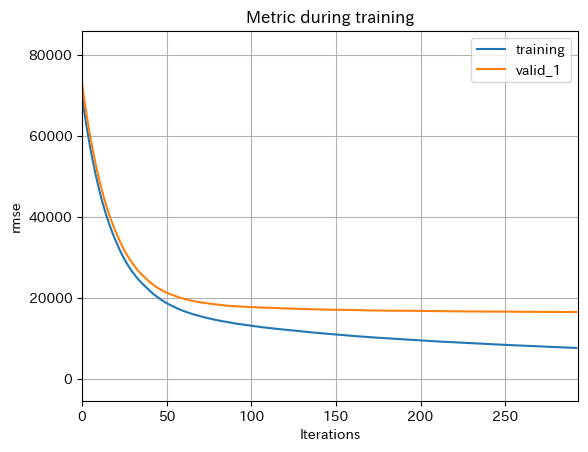

,importance
面積,4.525002e+14
L,3.995189e+14
平均地価,2.003394e+14
最寄り駅,9.047677e+13
築年数,6.474215e+13
...,...
Roberta-text681,3.664193e+09
Roberta-text726,3.071994e+09
Roberta-text758,2.991845e+09
Roberta-text437,2.038579e+09


In [38]:
n_split = 5
cv = KFold(n_splits=n_split, shuffle=True, random_state=0)
valid_rmses_list = []
valid_GBDT = np.zeros(X_train.shape[0])
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index,:]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train.loc[train_index]
    y_val = y_train.loc[valid_index]

    evals_result = {} 
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

    params = {
        'objective':'regression',
        'boosting_type':'gbdt',
        'metrics':'rmse',
        'learning_rate':0.05,
        'reg_lambda':  5.009615137983937e-06,
        'max_bin': 346,
        'num_leaves': 91,
    }

    print('Start training...')
    model = lgb.train(
                        params,
                        lgb_train, 
                        valid_sets=[lgb_train, lgb_eval], 
                        verbose_eval=10, 
                        num_boost_round=1000, 
                        early_stopping_rounds=10,
                        categorical_feature = category_lists,
                        evals_result=evals_result,
                        )

    pred_y_val = model.predict(X_val)
    rmse = mean_squared_error(y_val, pred_y_val, squared=False)
    valid_rmses_list.append(rmse)

valid_rmse = np.mean(valid_rmses_list)
print("whole valid rmse:", valid_rmse)

print('Start predicting...')
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
print('Plot metrics during training...')
ax = lgb.plot_metric(evals_result, metric='rmse')
plt.show()
# feature importanceを表示
importance = pd.DataFrame(model.feature_importance(importance_type = "gain"), index=X_train.columns, columns=['importance'])
df_importance = pd.DataFrame(importance)
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
display(df_importance)

In [39]:
df = pd.read_csv('../data/outer_data/test.csv')
id = df['id']
y_pred = pd.DataFrame(y_pred)
result = pd.concat([id, y_pred],axis=1)
result.to_csv('../data/result_data/text_BERT1_result.csv',index=False)